In [29]:
import os
import ast
import json
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import dask.dataframe as dd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from tabulate import tabulate
warnings.simplefilter(action='ignore')

In [1]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'] 

    df = dd.read_csv(csv_path,converters={column: json.loads for column in JSON_COLUMNS}, dtype={'fullVisitorId': 'str'}).head(n=nrows)
    print(df.shape) 
    for column in JSON_COLUMNS:
        #df[column] = df[column].apply(ast.literal_eval, meta=('object'))
        df[column] = df[column].apply(ast.literal_eval)
        
    for column in tqdm(JSON_COLUMNS):
        column_as_df = pd.json_normalize(df[column]) 
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns] 
                                                                                                           
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) 
                                                                                          
    unique_only_columns = []
    # Identifying columns with a single unique value
    for column in list(df.columns):
        if len(list(df[column].unique())) == 1:
            unique_only_columns.append(column)
    
    print(f"Columns with a single unique value: {unique_only_columns}")
    
    # Dropping columns with a single unique value
    for column in unique_only_columns:
        df = df.drop(column, axis=1)
        
    print("\nColumns after dropping those with only 1 unique value:")
    print(df.columns)    
    
    # Calculating percentage of missing values in each column
    dt = (df.isnull().sum() / len(df.index)) * 100
    missing_values = pd.DataFrame({'Columns': dt.index, 'Null Values Count': dt.values})
    
    print("\nPercentage of missing values in each column:")
    print(missing_values)
    
    # Dropping columns with more than 90% missing values, except for 'totals.transactionRevenue'
    for i in missing_values.index:
        column_name = missing_values.iloc[i]['Columns']
        null_percentage = missing_values.iloc[i]['Null Values Count']
        if null_percentage > 90 and column_name != 'totals.transactionRevenue':
            df= df.drop( missing_values.iloc[i]['Columns'] ,axis=1)

    
    print("\nColumns after dropping those with more than 90% missing values:")
    print(df.columns)
    df['totals.bounces'] = df['totals.bounces'].fillna(0)
    df['totals.newVisits'] = df['totals.newVisits'].fillna(0)
    df['totals.hits'] = df['totals.hits'].fillna(0)
    df['visitNumber'] = df['visitNumber'].fillna(0)
    df = df.astype({"totals.bounces":'int64', "totals.newVisits":'int64','totals.hits':'int64','visitNumber':'int64'}) 

    
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    return df

train_df = load_df('train.csv')
test_df = load_df('test.csv')
train_df['totals.transactionRevenue'] = pd.to_numeric(train_df['totals.transactionRevenue'].str.replace('[\$,]', '', regex=True), errors='coerce')
train_df.dropna(subset=['totals.transactionRevenue'], inplace=True)  # Drop rows with NaN revenue values


<>:60: SyntaxWarning: invalid escape sequence '\$'
<>:60: SyntaxWarning: invalid escape sequence '\$'
/var/folders/7p/nwhtyckd7b7_m26k6z5c170c0000gn/T/ipykernel_19147/3781274153.py:60: SyntaxWarning: invalid escape sequence '\$'
  train_df['totals.transactionRevenue'] = pd.to_numeric(train_df['totals.transactionRevenue'].str.replace('[\$,]', '', regex=True), errors='coerce')
/var/folders/7p/nwhtyckd7b7_m26k6z5c170c0000gn/T/ipykernel_19147/3781274153.py:60: SyntaxWarning: invalid escape sequence '\$'
  train_df['totals.transactionRevenue'] = pd.to_numeric(train_df['totals.transactionRevenue'].str.replace('[\$,]', '', regex=True), errors='coerce')


NameError: name 'dd' is not defined

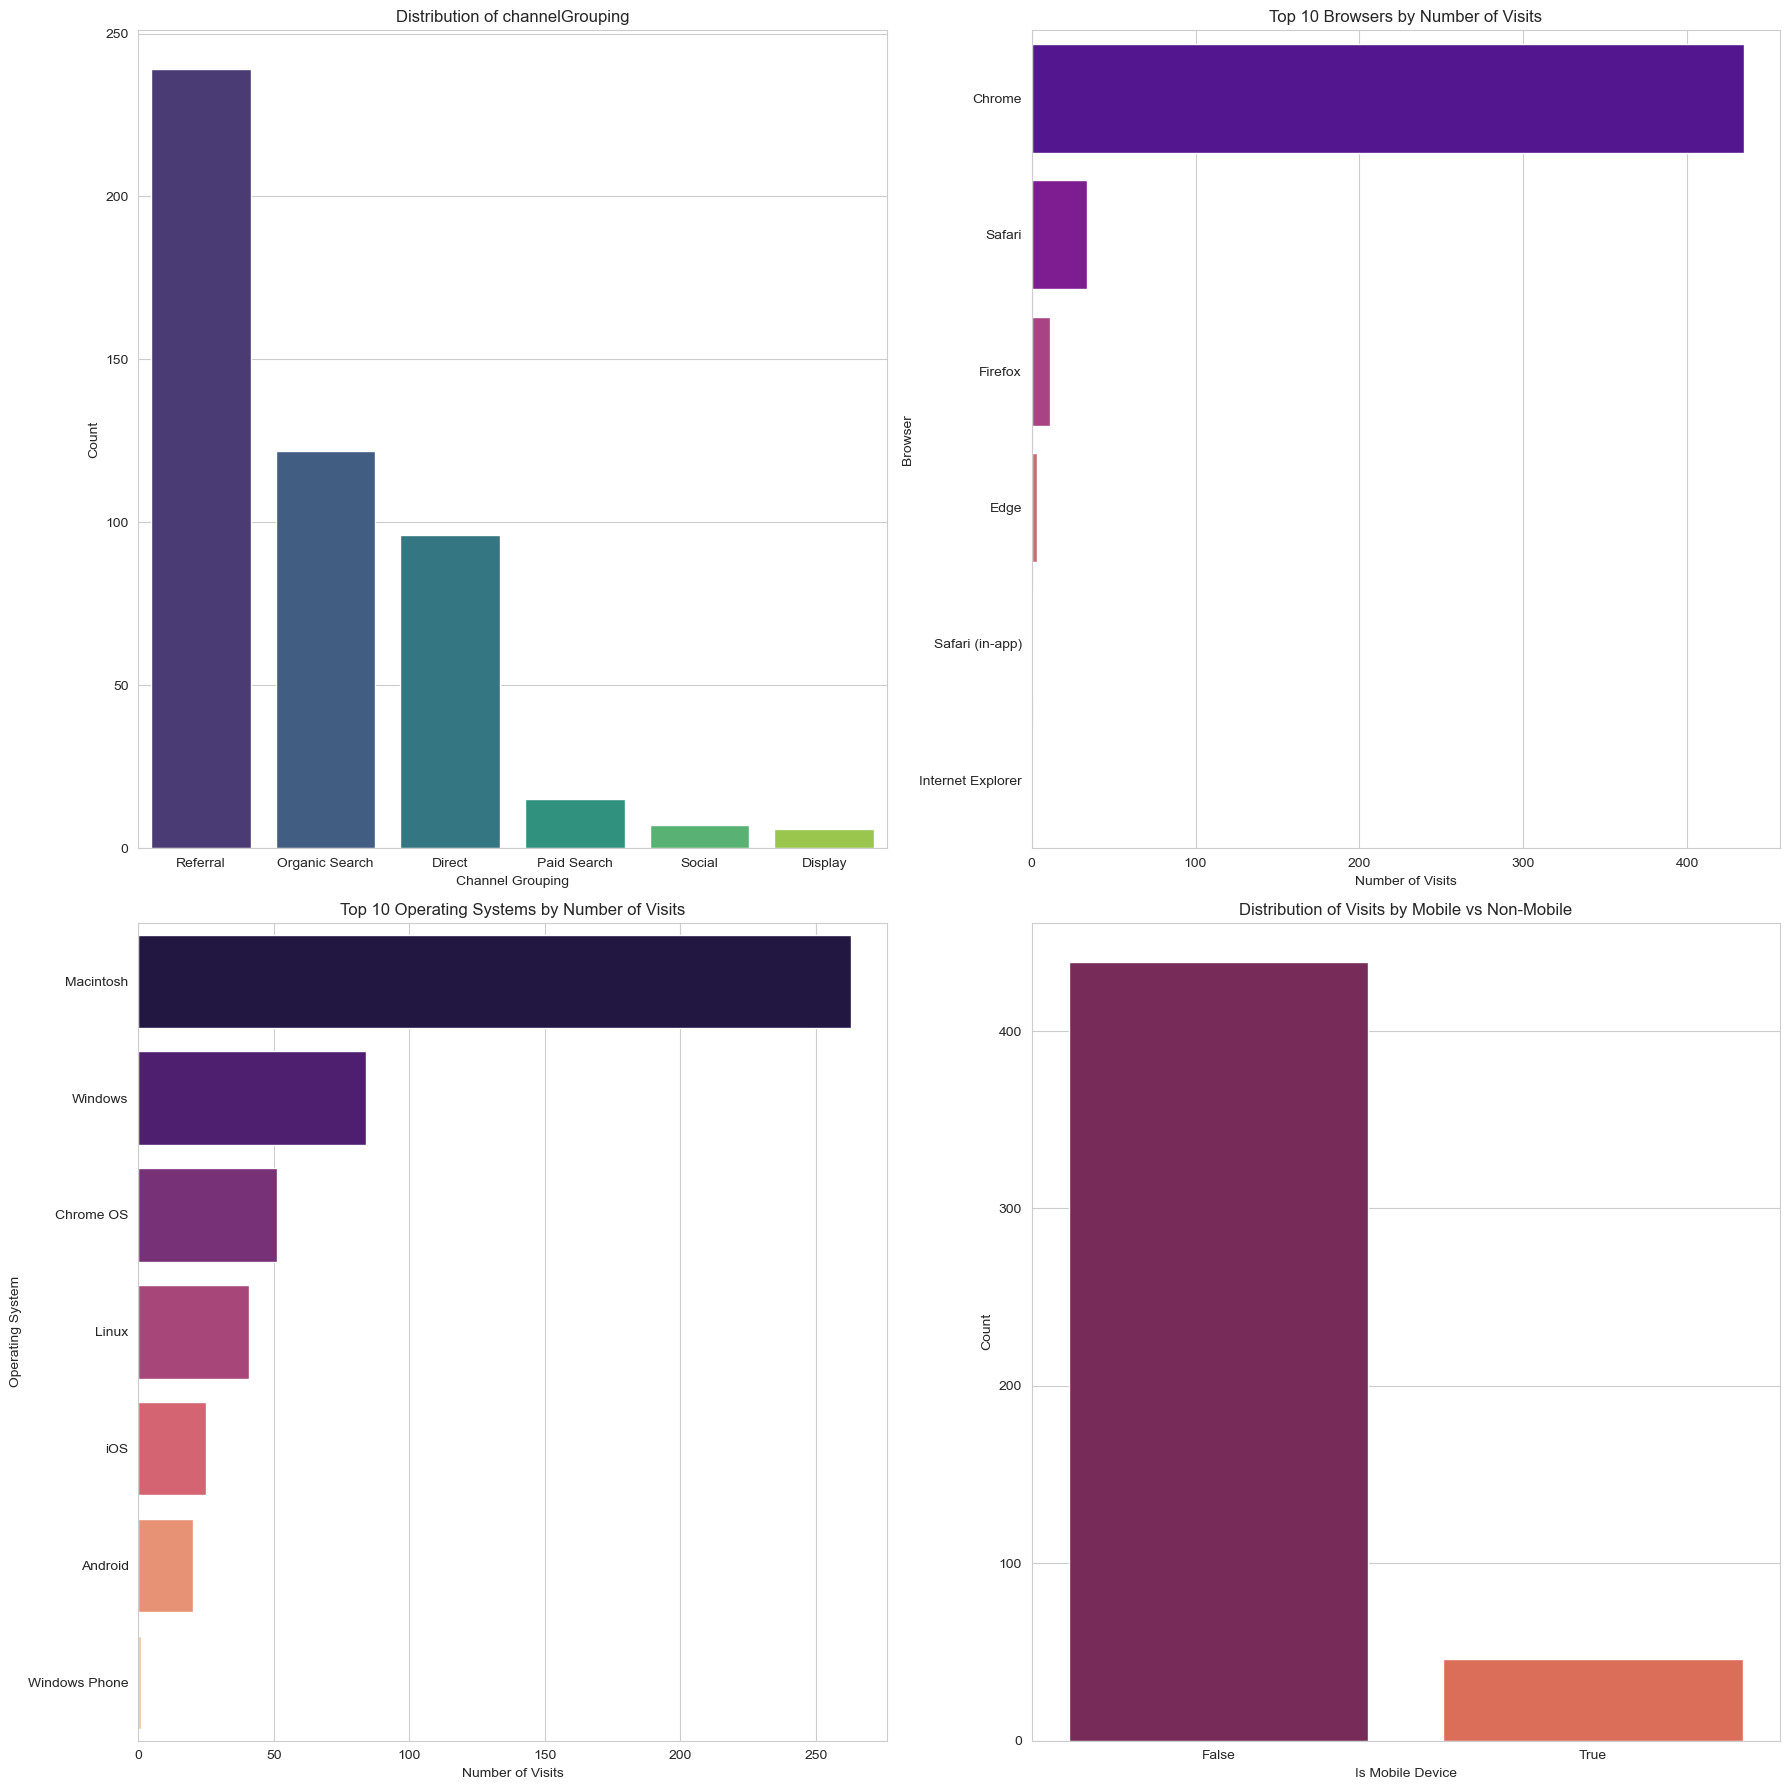

In [23]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(18, 18))

# Distribution of channelGrouping
channel_counts = train_df['channelGrouping'].value_counts()
sns.barplot(x=channel_counts.index, y=channel_counts.values, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Distribution of channelGrouping')
axes[0, 0].set_xlabel('Channel Grouping')
axes[0, 0].set_ylabel('Count')

# Distribution of Visits by Browser
browser_counts = train_df['device.browser'].value_counts().head(10)
sns.barplot(x=browser_counts.values, y=browser_counts.index, orient='h', ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Top 10 Browsers by Number of Visits')
axes[0, 1].set_xlabel('Number of Visits')
axes[0, 1].set_ylabel('Browser')

# Distribution of Visits by Operating System
os_counts = train_df['device.operatingSystem'].value_counts().head(10)
sns.barplot(x=os_counts.values, y=os_counts.index, orient='h', ax=axes[1, 0], palette='magma')
axes[1, 0].set_title('Top 10 Operating Systems by Number of Visits')
axes[1, 0].set_xlabel('Number of Visits')
axes[1, 0].set_ylabel('Operating System')

# Distribution of Visits by Mobile vs Non-Mobile
mobile_counts = train_df['device.isMobile'].value_counts()
sns.barplot(x=mobile_counts.index, y=mobile_counts.values, ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title('Distribution of Visits by Mobile vs Non-Mobile')
axes[1, 1].set_xlabel('Is Mobile Device')
axes[1, 1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.savefig('visualization1.png')
plt.show()

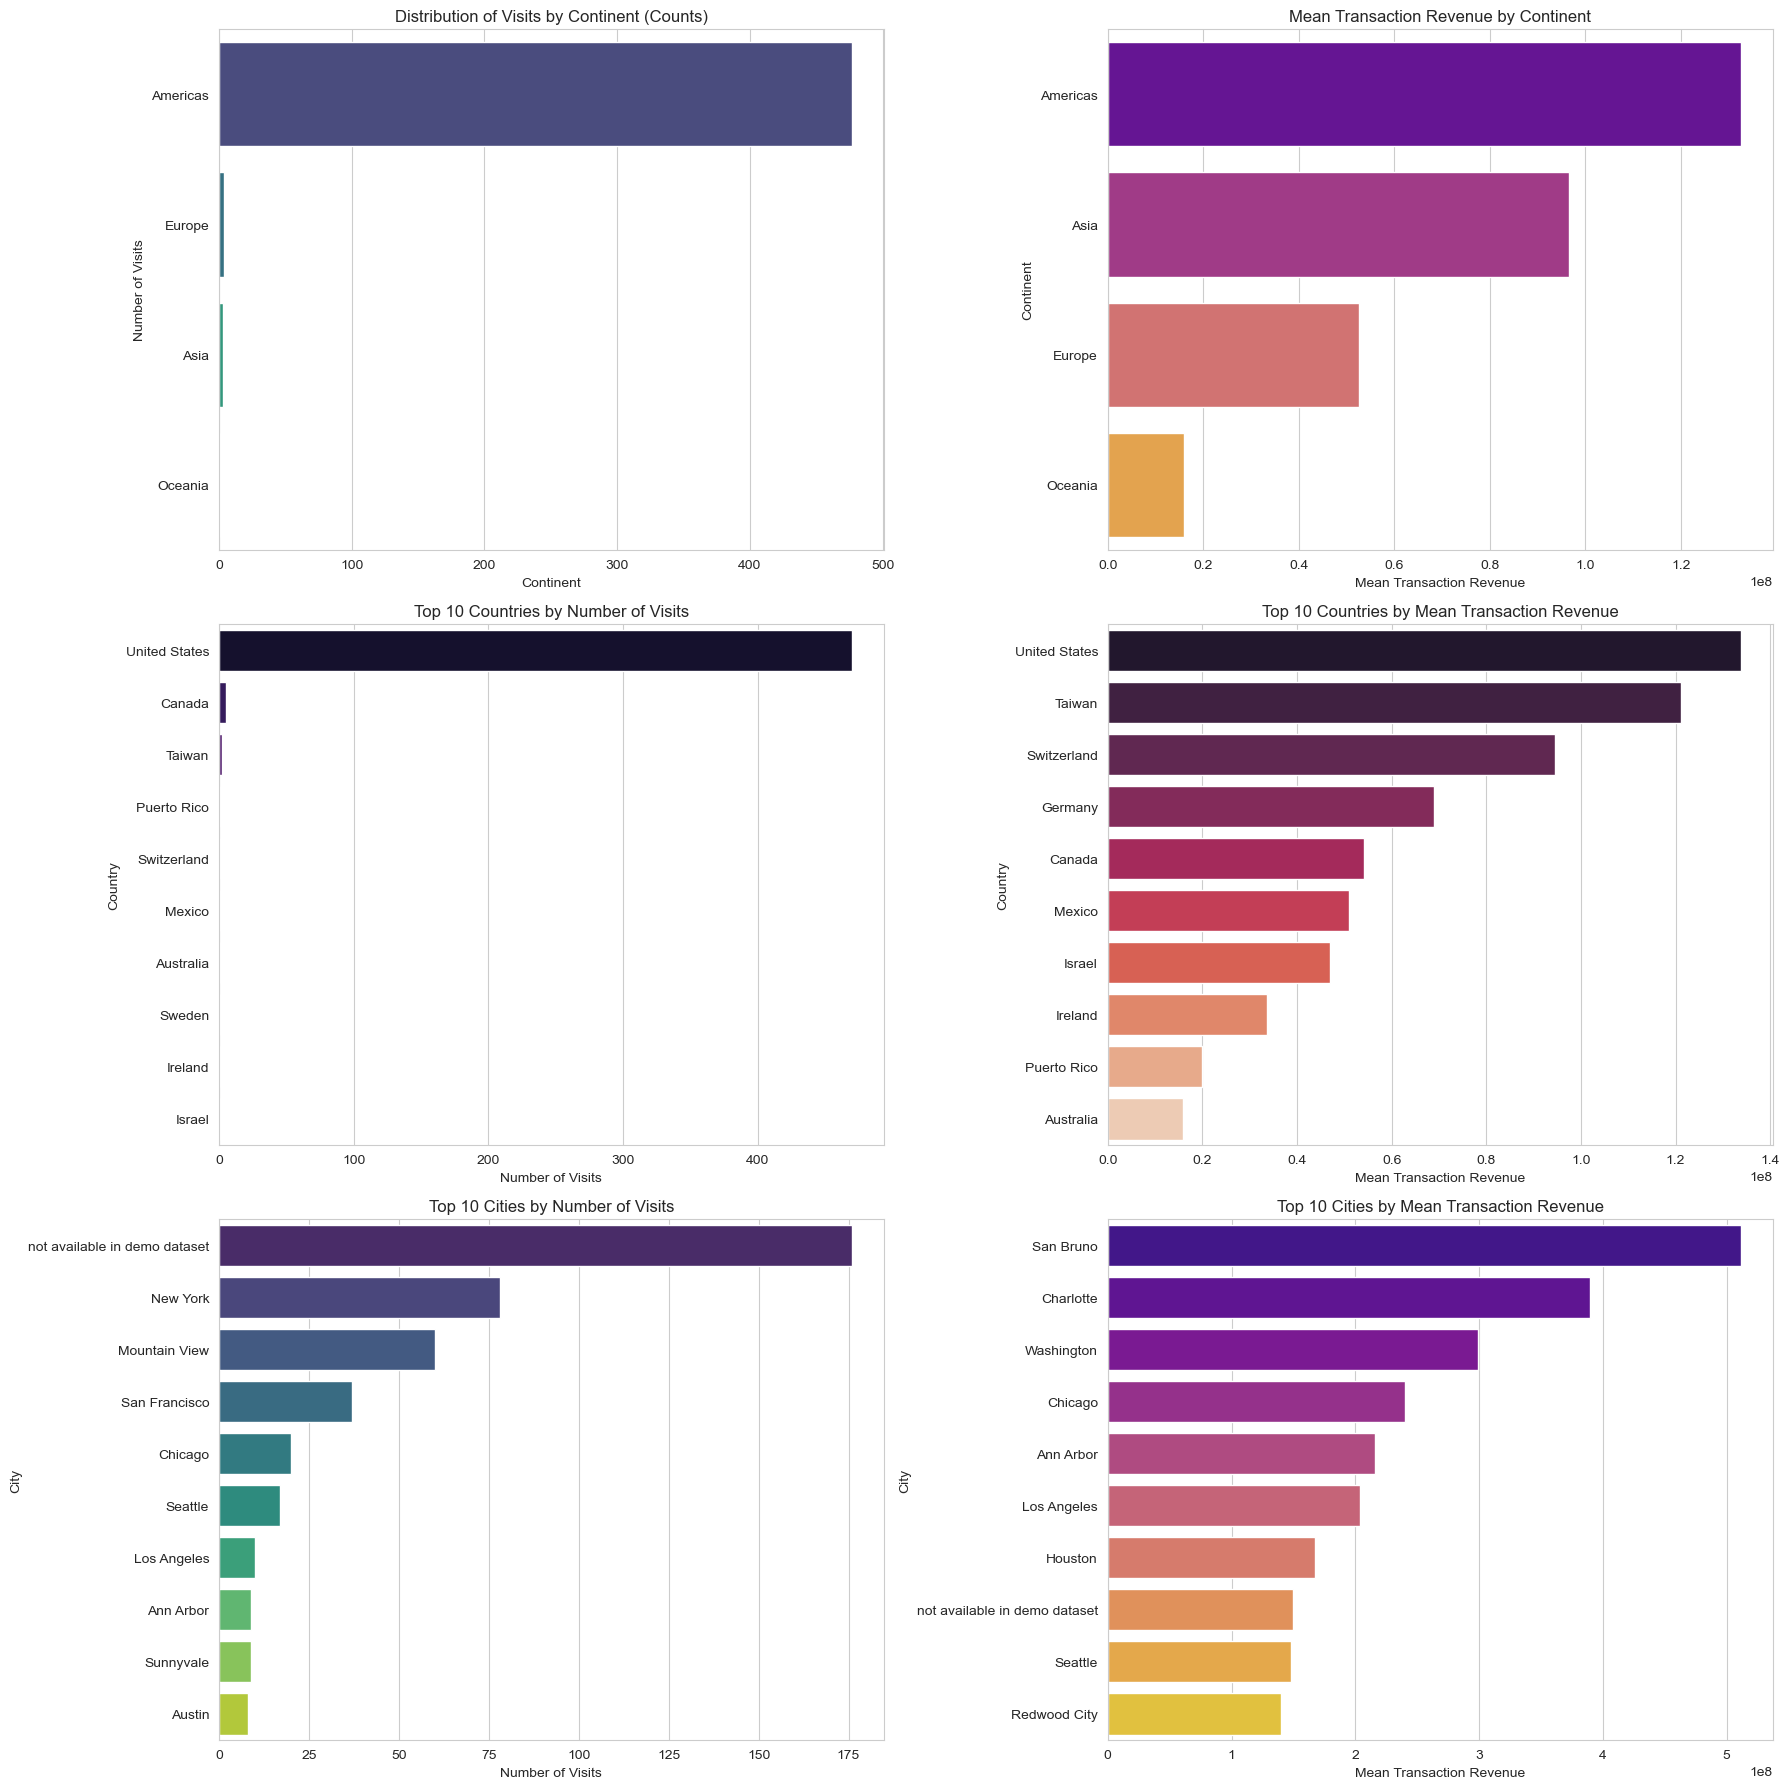

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Distribution of Visits by Continent (Counts)
continent_counts = train_df['geoNetwork.continent'].value_counts()
sns.barplot(x=continent_counts.values, y=continent_counts.index, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Distribution of Visits by Continent (Counts)')
axes[0, 0].set_xlabel('Continent')
axes[0, 0].set_ylabel('Number of Visits')

# Distribution of Visits by Continent (Mean Transaction Revenue)
revenue_by_continent = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].mean().sort_values(ascending=False)
sns.barplot(x=revenue_by_continent.values, y=revenue_by_continent.index, ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Mean Transaction Revenue by Continent')
axes[0, 1].set_xlabel('Mean Transaction Revenue')
axes[0, 1].set_ylabel('Continent')

# Top 10 Countries by Number of Visits
top_countries = train_df['geoNetwork.country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, orient='h', ax=axes[1, 0], palette='magma')
axes[1, 0].set_title('Top 10 Countries by Number of Visits')
axes[1, 0].set_xlabel('Number of Visits')
axes[1, 0].set_ylabel('Country')

# Top 10 Countries by Mean Transaction Revenue
revenue_by_country = train_df.groupby('geoNetwork.country')['totals.transactionRevenue'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=revenue_by_country.values, y=revenue_by_country.index, orient='h', ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title('Top 10 Countries by Mean Transaction Revenue')
axes[1, 1].set_xlabel('Mean Transaction Revenue')
axes[1, 1].set_ylabel('Country')

# Top 10 Cities by Number of Visits
top_cities = train_df['geoNetwork.city'].value_counts().head(10)
sns.barplot(x=top_cities.values, y=top_cities.index, orient='h', ax=axes[2, 0], palette='viridis')
axes[2, 0].set_title('Top 10 Cities by Number of Visits')
axes[2, 0].set_xlabel('Number of Visits')
axes[2, 0].set_ylabel('City')

# Top 10 Cities by Mean Transaction Revenue
revenue_by_city = train_df.groupby('geoNetwork.city')['totals.transactionRevenue'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=revenue_by_city.values, y=revenue_by_city.index, orient='h', ax=axes[2, 1], palette='plasma')
axes[2, 1].set_title('Top 10 Cities by Mean Transaction Revenue')
axes[2, 1].set_xlabel('Mean Transaction Revenue')
axes[2, 1].set_ylabel('City')

# Adjust layout
plt.tight_layout()
plt.savefig('visualization2.png')
plt.show()

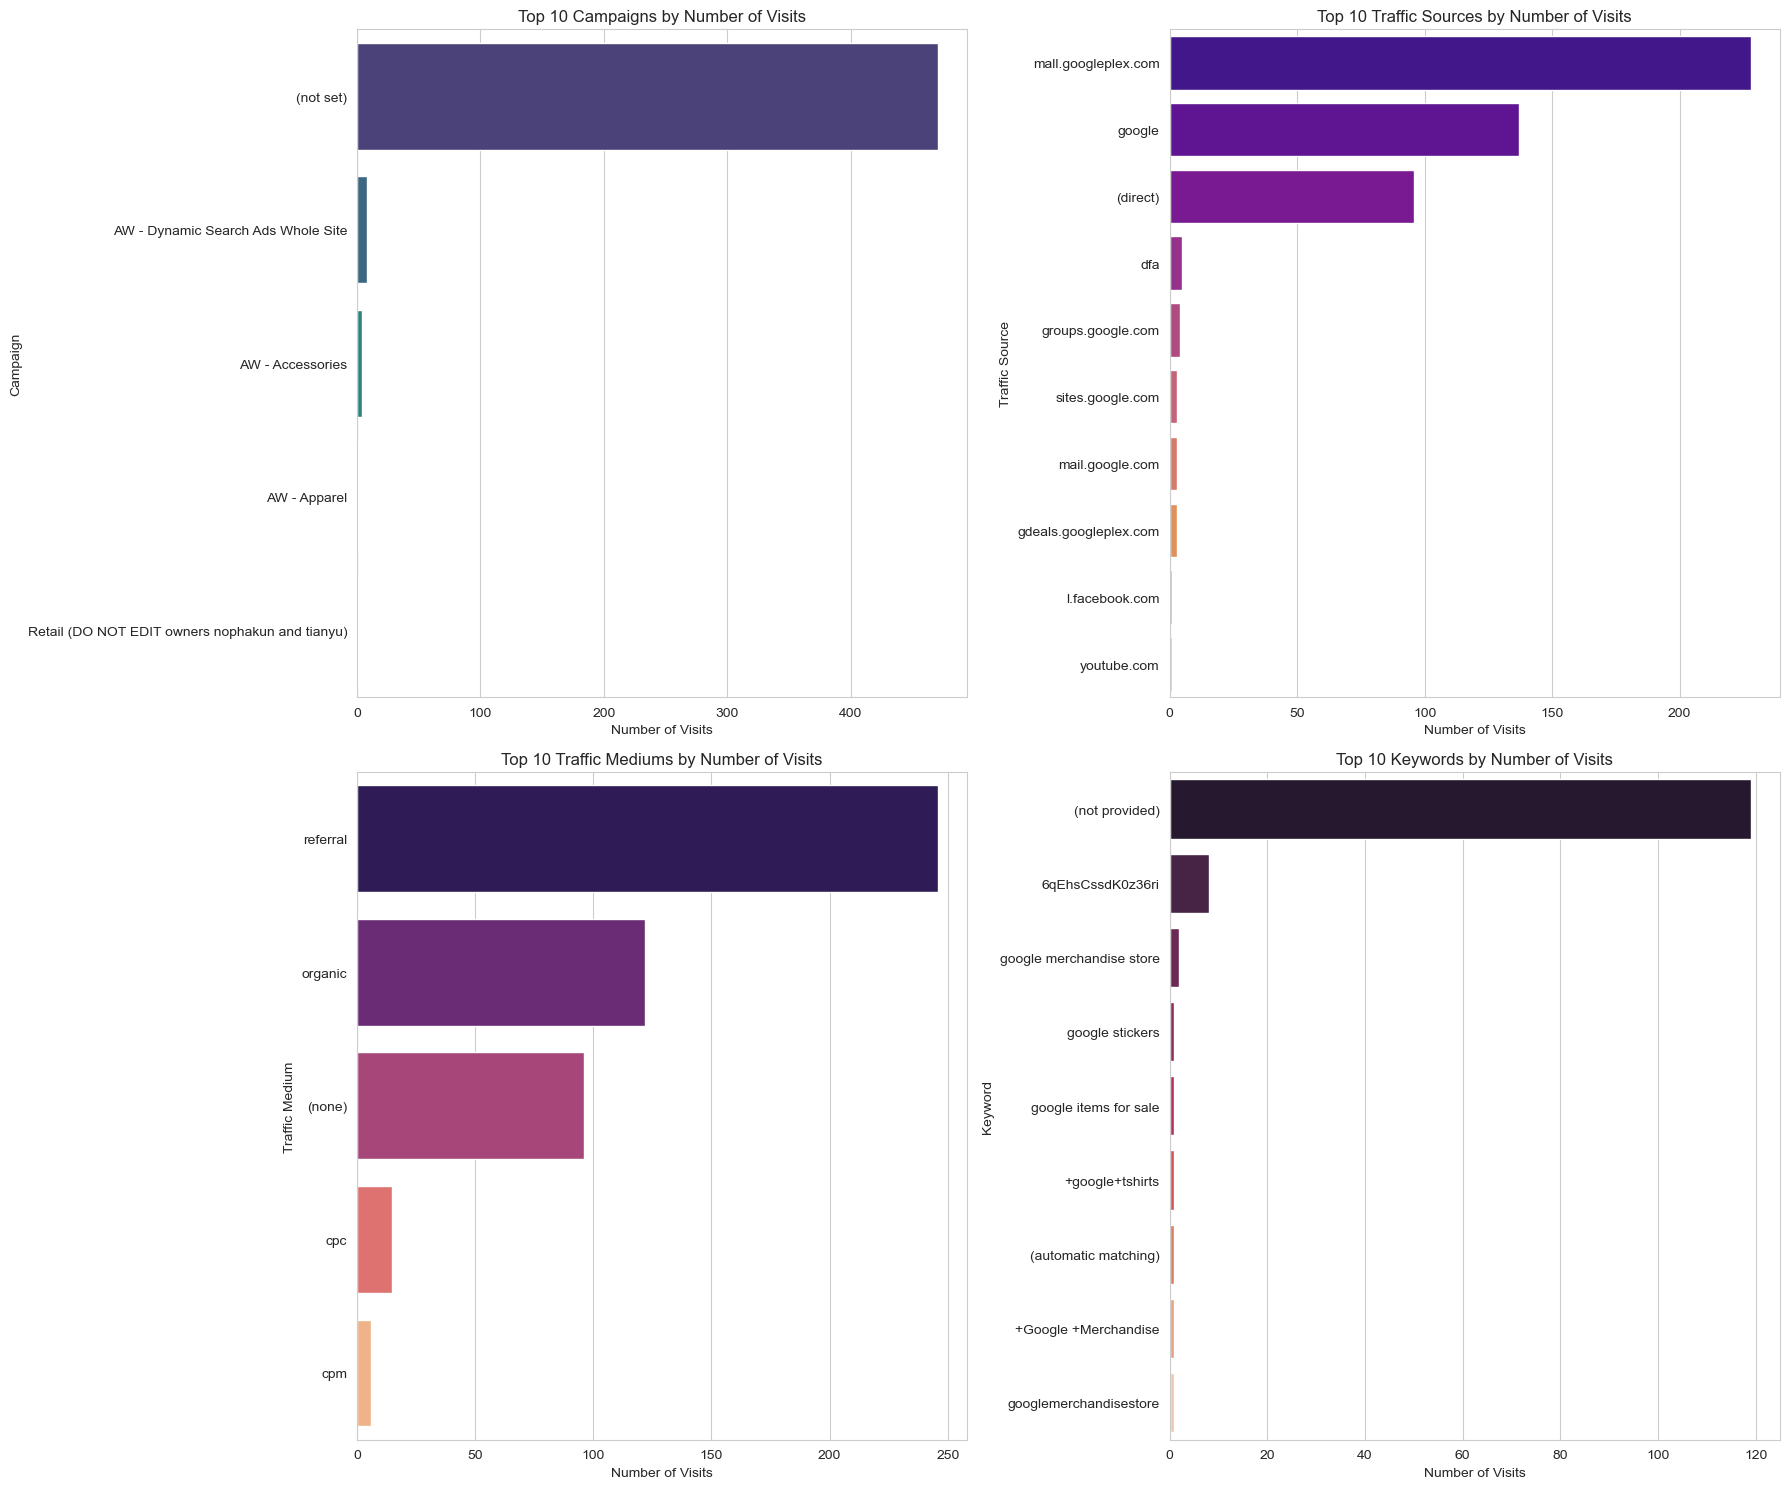

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))

# Distribution of trafficSource.campaign
campaign_counts = train_df['trafficSource.campaign'].value_counts().head(10)
sns.barplot(x=campaign_counts.values, y=campaign_counts.index, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Top 10 Campaigns by Number of Visits')
axes[0, 0].set_xlabel('Number of Visits')
axes[0, 0].set_ylabel('Campaign')

# Distribution of trafficSource.source
source_counts = train_df['trafficSource.source'].value_counts().head(10)
sns.barplot(x=source_counts.values, y=source_counts.index, ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Top 10 Traffic Sources by Number of Visits')
axes[0, 1].set_xlabel('Number of Visits')
axes[0, 1].set_ylabel('Traffic Source')

# Distribution of trafficSource.medium
medium_counts = train_df['trafficSource.medium'].value_counts().head(10)
sns.barplot(x=medium_counts.values, y=medium_counts.index, ax=axes[1, 0], palette='magma')
axes[1, 0].set_title('Top 10 Traffic Mediums by Number of Visits')
axes[1, 0].set_xlabel('Number of Visits')
axes[1, 0].set_ylabel('Traffic Medium')

# Distribution of trafficSource.keyword
keyword_counts = train_df['trafficSource.keyword'].value_counts().head(10)
sns.barplot(x=keyword_counts.values, y=keyword_counts.index, ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title('Top 10 Keywords by Number of Visits')
axes[1, 1].set_xlabel('Number of Visits')
axes[1, 1].set_ylabel('Keyword')

# Adjust layout
plt.tight_layout()
plt.savefig('visualization3.png')
plt.show()

In [30]:
# Define models and their parameters for GridSearchCV
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'classifier__alpha': [0.1, 1.0, 10.0]  # Example values for alpha
        }
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {
            'classifier__alpha': [0.1, 1.0, 10.0]  # Example values for alpha
        }
    }
}

results = []
combined_results = []

# Define mapping dictionary
mapping = {
    'Direct': 1,
    'Organic Search': 2,
    'Referral': 3,
    'Display': 4,
    'Paid Search': 5,
    'Social': 6
}

# Replace values in 'channelGrouping' column
train_df['channelGrouping'] = train_df['channelGrouping'].map(mapping)

# Log transform the target variable
train_df['log_transactionRevenue'] = np.log1p(train_df['totals.transactionRevenue'])

# Define numerical and categorical features
numerical_features = ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits']
categorical_features = ['device.browser', 'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
                        'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
                        'geoNetwork.metro', 'geoNetwork.city', 'trafficSource.campaign', 'trafficSource.source',
                        'trafficSource.medium', 'trafficSource.keyword', 'trafficSource.isTrueDirect',
                        'trafficSource.referralPath']

# Preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Split the data
X = train_df.drop(columns=['totals.transactionRevenue', 'log_transactionRevenue', 'fullVisitorId'])
y = train_df['log_transactionRevenue']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate each model
best_model = None
best_r2 = -np.inf

for model_name, model_dict in models.items():
    model = model_dict['model']
    params = model_dict['params']

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    grid_search = GridSearchCV(model_pipeline, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_estimator = grid_search.best_estimator_
    val_preds = best_estimator.predict(X_val)

    mae = mean_absolute_error(y_val, val_preds)
    mse = mean_squared_error(y_val, val_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, val_preds)

    model_results = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
    }

    combined_results.append(model_results)

combined_results_df = pd.DataFrame(combined_results)
print(f"{'*'*25} Model Scores {'*'*25}")
print(tabulate(combined_results, headers='keys', tablefmt='psql'))

************************* Model Scores *************************
+-------------------+----------+---------+---------+------------+
| Model             |      MAE |     MSE |    RMSE |   R2 Score |
|-------------------+----------+---------+---------+------------|
| Linear Regression | 0.861847 | 1.19721 | 1.09417 |   0.070018 |
| Ridge Regression  | 0.81654  | 1.03818 | 1.01891 |   0.193546 |
| Lasso Regression  | 0.839011 | 1.14179 | 1.06855 |   0.113063 |
+-------------------+----------+---------+---------+------------+
